# 5장 머신러닝의 핵심 이슈

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 머신러닝의 핵심 이슈 이해: 모델 일반화와 모델 훈련 최적화 사이의 관계 조율
- 머신러닝 모델 평가 기법
- 모델 훈련 최적화 기법
- 모델 일반화 성능 향상 기법

## 5.1 머신러닝의 목표: 모델 일반화

훈련을 많이 할 수록 모델은 훈련 세트에 대해 보다 좋은 성능을 보이지만 새로운 데이터에 대한 
성능은 점점 떨어지는 과대적합 현상이 언제나 발생한다. 
머신러닝의 핵심 이슈는 모델 훈련의 **최적화**(optimization)와 
모델 **일반화**(generalization) 사이의 관계를 적절히 조절하는 것이다.

- **최적화**: 훈련 세트에 대해 가장 좋은 성능을 이끌어 내는 과정
- **일반화**: 처음 보는 데이터를 처리하는 모델의 능력

### 과소적합과 과대적합

- 과소적합
    - 훈련 초반
    - 훈련셋과 검증셋 모두에 대해 성능이 향상되는 과정
    - 신경망이 훈련셋의 패턴을 아직 덜 파악한 상태

- 과대적합
    - 훈련셋 고유의 패턴을 학습하기 시작
    - 새로운 데이터와 무관하거나 혼동을 주는 패턴 학습

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/typical_overfitting.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 일반화 성능이 좋은 모델 대 과대적합 모델

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/outliers_and_overfitting.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 과대적합 발생 주요 요인

과대적합을 발생시키는 요소는 크게 세 가지로 나뉜다.

##### 첫째, 소음(noise) 섞인 훈련셋.

- 적절하지 않은 데이터 또는 잘못된 레이블을 갖는 데이터 등을 **소음** 또는 **노이즈**(noise)라 부름.
- 적절하지 않은 데이터: 다음 MNNIST 이미지들처럼 불분명하면 특성 파악 어려움.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/fucked_up_mnist.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 잘못된 레이블: 예를 들어, 잘못 분류된 1처럼 생긴 이미지를 7로 잘못 분류할 가능성이 높아짐.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/mislabeled_mnist.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

##### 둘째, 애매한 특성.

- 소음이 전혀 없는 데이터라 하더라도 특정 특성 영역이 여러 레이블과 연관될 수 있음.

- 예제: 붓꽃 데이터의 꽃잎 길이와 너비를 활용한 
    버시컬러(versicolor) 품종과 버지니카(virginica) 품종의 완벽한 구분 불가능.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch05/homl05-03b.png" style="width:500px;"></div>

##### 셋째: 매우 드문 특성 또는 거짓 상관관계

- 매우 드문 특성
    - 예제: IMDB 데이터셋에서 매우 낮은 빈도로 사용되는 단어를 훈련셋에서 포함시키는 경우
        어쩌다 한 번 사용되는 특성으로 인해 잘못된 판단이 유도될 수 있음.

- 거짓된 상관관계를 유발하는 훈련셋
- 예제: MNIST 데이터셋에 **백색 소음**(white noise)이 포함된 데이터셋과 그렇지 않은 데이터셋 비교 참조.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

# MNIST 데이터셋 적재 및 전처리
(train_images, train_labels), _ = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

# 백색 소음 추가
train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

# 크기를 맞추기 위해 영 행렬 추가
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

In [2]:
train_images_with_noise_channels.shape

(60000, 1568)

In [3]:
train_images_with_zeros_channels.shape

(60000, 1568)

백색 소음이 들어간 샘플은 다음과 같이 보인다.

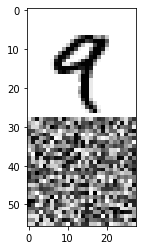

In [4]:
train_image_white4 = train_images_with_noise_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_white4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

영 행렬이 추가된 샘플은 다음과 같이 보인다.

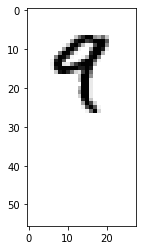

In [5]:
train_image_zeros4 = train_images_with_zeros_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_zeros4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

모델 구성과 컴파일을 함수를 이용하여 지정한다.

- 정수 레이블을 사용하기에 손실함수로 `sparse_categorical_crossentropy` 지정해야 함.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

- 백색 소음이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [7]:
# 모델 생성 및 훈련
model = get_model()

history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 4ms/step - loss: 0.6309 - accuracy: 0.8112 - val_loss: 0.3331 - val_accuracy: 0.8964
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2431 - accuracy: 0.9241 - val_loss: 0.1763 - val_accuracy: 0.9468
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1570 - accuracy: 0.9515 - val_loss: 0.1601 - val_accuracy: 0.9526
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1130 - accuracy: 0.9647 - val_loss: 0.1261 - val_accuracy: 0.9622
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0837 - accuracy: 0.9734 - val_loss: 0.1248 - val_accuracy: 0.9624
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0602 - accuracy: 0.9806 - val_loss: 0.1742 - val_accuracy: 0.9490
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.1491 - val_accuracy: 0.9600
Epoch 

- 영 행렬이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [8]:
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2860 - accuracy: 0.9175 - val_loss: 0.1618 - val_accuracy: 0.9525
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1187 - accuracy: 0.9650 - val_loss: 0.1039 - val_accuracy: 0.9695
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0781 - accuracy: 0.9768 - val_loss: 0.0893 - val_accuracy: 0.9737
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0557 - accuracy: 0.9837 - val_loss: 0.0837 - val_accuracy: 0.9763
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0415 - accuracy: 0.9878 - val_loss: 0.0809 - val_accuracy: 0.9762
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0320 - accuracy: 0.9910 - val_loss: 0.0839 - val_accuracy: 0.9763
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0243 - accuracy: 0.9928 - val_loss: 0.0855 - val_accuracy: 0.9767
Epoch 

- 정확도 비교: 백색 소음이 포함된 훈련셋을 이용한 모델의 정확도 성능이 1% 이상 낮음.

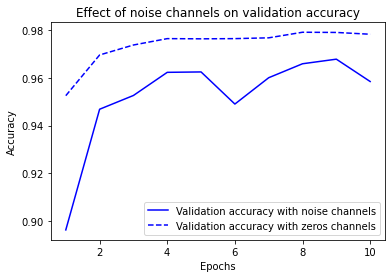

In [9]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)

plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")

plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**특성 선택**

- 과대적합 문제를 위해 훈련에 유용한 특성을 선택해야함.
    - IMDB 예제: 빈도수 10,000 등 이내의 단어만 사용
    - 백색 소음 예제: 백색 소음 부분 제거
- 하지만 유용한 특성을 선택하는 일이 기본적으로 불가능하거나 매우 어려움.

### 딥러닝 모델 일반화의 핵심

아래 예제에서 확인할 수 있듯이 딥러닝 모델은 어떤 무엇도 학습할 수 있다.

**예제: MNIST 모델을 임의로 섞은 레이블과 함께 훈련시키기**

아래 코드는 임의로 섞은 레이블을 이용하여 손글씨를 예측하는 모델을 훈련시킨다. 

In [10]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_images, random_train_labels,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3159 - accuracy: 0.1024 - val_loss: 2.3053 - val_accuracy: 0.1042
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3008 - accuracy: 0.1167 - val_loss: 2.3097 - val_accuracy: 0.1025
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2914 - accuracy: 0.1252 - val_loss: 2.3156 - val_accuracy: 0.0996
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2785 - accuracy: 0.1390 - val_loss: 2.3214 - val_accuracy: 0.1053
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2613 - accuracy: 0.1512 - val_loss: 2.3332 - val_accuracy: 0.1018
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2407 - accuracy: 0.1679 - val_loss: 2.3441 - val_accuracy: 0.1057
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2168 - accuracy: 0.1829 - val_loss: 2.3637 - val_accuracy: 0.1046

Epoch 58/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9727 - accuracy: 0.6769 - val_loss: 4.5107 - val_accuracy: 0.1001
Epoch 59/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9582 - accuracy: 0.6816 - val_loss: 4.5956 - val_accuracy: 0.1019
Epoch 60/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9429 - accuracy: 0.6856 - val_loss: 4.6587 - val_accuracy: 0.0976
Epoch 61/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9329 - accuracy: 0.6896 - val_loss: 4.7057 - val_accuracy: 0.1013
Epoch 62/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9168 - accuracy: 0.6939 - val_loss: 4.7623 - val_accuracy: 0.1022
Epoch 63/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9026 - accuracy: 0.6995 - val_loss: 4.7929 - val_accuracy: 0.1022
Epoch 64/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8889 - accuracy: 0.7042 - val_loss: 4.8807 - val_accuracy:

훈련셋에 대한 성능은 훈련하면서 계속 향상되지만 검증셋에 성능은 전혀 향상되지 않는다.

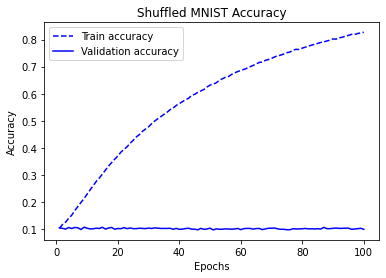

In [11]:
import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, 101)

plt.plot(epochs, train_acc, "b--",
         label="Train accuracy")

plt.plot(epochs, val_acc, "b-",
         label="Validation accuracy")

plt.title("Shuffled MNIST Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

위 결과는 다음을 의미한다.

- 일반화는 모델 훈련 과정 중에 제어할 수 있는 대상이 아니다. 
- 모델 훈련을 통해 할 수 있는 것은 주어진 훈련 데이터셋에 모델이 적응하도록 하는 것 뿐이다.
- 딥러닝 모델은 어떤 데이터셋에도 적응할 수 있기에 
    너무 오래 훈련시키면 과대적합은 반드시 발생하고 일반화는 어려워진다. 

결론적으로 **일반화**가 모델 보다는 사용되는 **데이터셋 내부에 존재하는 정보 구조**와 
보다 밀접히 관련된다고 볼 수 있다. 

#### 다양체 가설

일반적인 데이터셋은 고차원상에 존재하는 (저차원의) 연속이며 미분가능한 다양체를 구성한다는 가설이
**다양체 가설**(manifold hypothesis)이다.
그리고 모델 훈련은 바로 이 다양체를 찾아가는 과정이다. 

**참고**: 이런 의미에서 무작위로 섞은 레이블을 사용하는 위 MNIST 예제는 일반적인 데이터셋이 될 수 없다. 

아래 이미지는 3차원 공간에 존재하는 2차원 다양체를 고차원 상의 다양체로 변환하여 선형 분류가 가능한
데이터셋을 구성하는 과정을 보여준다.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch08/homl08-13.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 8장](https://github.com/ageron/handson-ml2)

다양체 가설을 이용하면 적절하게 구성된 모델이 적절한 훈련셋으로 훈련받았을 때 새로운 데이터에 대해 적절한 예측을 할 수 있는 이유를 설명할 수 있다.
즉, 모델이 찾은 연속이며 미분가능한 다양체와 학습된 데이터 정보에 **보간법**을 적용하여 새로운 데이터에 대해 예측을 실행한다.

#### 보간법

**보간법**(interpolation)은 모델 훈련에 사용된 훈련셋의 데이터와 새로운 데이터를 연결하는 
다양체 상의 경로를 이용하여 예측값을 실행하는 것을 의미한다. 
보다 큰 훈련셋을 사용할 수록 보간법이 보다 잘 작동하지만 
**차원의 저주**(curse of dimensions)로 인해 충분한 크기의 훈련셋 구하기가 
일반적으로 불가능하거나 매우 어렵다. 
    
**참고**: 사람은 보간법 이외의 다른 능력을 사용하여 사물 예측과 구분, 주변 파악, 상황 판단 등 
일반화를 실행한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dense_sampling.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 충분치 않은 훈련셋과 정규화

충분히 큰 훈련셋을 준비하지 못하면 예측 과정에서 과대한 추측을 하게되어 과대적합이 발생할 가능성이 높다.
이를 방지하기 위해 일반적으로 두 가지 방법을 사용한다.

- 모델에 저장되는 정보를 적절하게 조정하기
- 모델이 생성하는 다양체의 곡률 완화

위 두 방법을 통해 데이터셋의 너무 세세한 패턴 보다는 가장 눈에 띄는 핵심적인 패턴에 모델이 집중하도록 한다.
이런식으로 과대적합을 방지하여 일반화를 향상시키는 기법을 **정규화**(regularization)이라 부른다.

## 5.2 모델 평가

모델의 일반화 능력을 향상시키려면 주어진 모델의 일반화 능력을 평가할 수 있어야 하며,
이를 위해 데이터셋을 훈련셋, 검증셋, 테스트셋으로 구분하는 이유를 먼저 알아야 한다. 

### 모델 튜닝과 정보 유출

훈련셋, 테스트셋 이외에 검증셋을 사용해야 하는 이유는 
무엇보다도 **최적의 모델을 구성할 때 검증셋에 대한 결과가 반영되기 때문**이다. 

테스트셋은 모델 구성과 훈련에 전혀 관여하지 않아야 한다.
따라서 구성된 모델의 성능을 평가하려면 테스트셋을 제외한 다른 데이터셋이 필요하고
이를 위해 훈련셋의 일부를 검증셋으로 활용한다.
검증셋은 훈련 과정 중에 일반화 성능을 테스트하는 용도로 사용되며
이를 통해 레이어 종류 및 개수, 레이어 별 유닛 개수 등 모델 구성에 필요한
**하이퍼파라미터**(hyperparameter)를 조정한다. 
이것을 **모델 튜닝**(model tuning)이라 하며,
바로 이 모델 튜닝을 위해 검증셋이 사용되는 것이다. 

모델 튜닝도 모델의 좋은 하이퍼파라미터를 찾아가는 일종의 **학습**이다. 
따라서 튜닝을 많이 하게되면 검증셋에 대한 과대적합이 발생한다.
다시 말해, 검증셋에 특화된 튜닝을 하게 되어 모델의 일반화 성능이 떨어질 수 있게 된다. 
이런 현상을 **정보 유출**이라 부르는데,
이유는 튜닝을 하면 할 수록 검증셋에 대한 보다 많은 정보가 모델로 흘려들어가기 때문이다. 

**참고**: 하이퍼파라미터와 파라미터는 다르다. 
파라미터(parameter)는 모델 훈련 중에 학습되는 가중치, 편향 등을 가리킨다. 

### 훈련셋, 검증셋, 테스트셋 분류 방법

데이터셋을 훈련셋, 검증셋, 테스트셋으로 분류하여 모델을 훈련을 진행하는
전형적인 방식 세 가지를 소개한다. 

#### 홀드아웃(hold-out) 검증

훈련셋의 일부를 검증셋으로 사용하는 가장 일반적인 방법이며,
모델 훈련 후에 테스트셋을 이용하여 모델의 일반화 성능을 확인한다.
하지만 그 이후에 모델 튜닝을 진행하지 않아야 한다. 

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/holdout_validation.png" style="width:400px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

홀드아웃 검증의 전형적인 패턴은 다음과 같다.

---
```python
num_validation_samples = 10000

np.random.shuffle(data)

validation_data = data[:num_validation_samples]
training_data = data[num_validation_samples:]

model = get_model()
model.fit(training_data, ...)

validation_score = model.evaluate(validation_data, ...)

...

model = get_model()
model.fit(np.concatenate([training_data,
                          validation_data]), ...)

test_score = model.evaluate(test_data, ...)
```
---

#### K-겹 교차검증

모델의 성능이 사용되는 훈련셋에 따라 심하게 달라질 때 추천되는 검증기법이다. 

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/k_fold_validation.png" style="width:650px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

K-겹 교차검증의 전형적인 패턴은 다음과 같다.

---
```python
k = 3
num_validation_samples = len(data) // k

np.random.shuffle(data)

validation_scores = []

for fold in range(k):
    validation_data = data[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate(
        data[:num_validation_samples * fold],
        data[num_validation_samples * (fold + 1):])
    
    model = get_model()
    model.fit(training_data, ...)
    
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)

validation_score = np.average(validation_scores)

model = get_model()
model.fit(data, ...)

test_score = model.evaluate(test_data, ...)
```
---

#### 반복 K-겹 교차검증

훈련셋의 크기가 너무 작거나 모델의 성능을 최대한 정확하게 평가하기 위해 사용된다.
K-겹 교차검증을 여러 번 실행한다. 대신 매번 훈련셋을 무작위로 섞은 뒤에
교차검증을 실행한다. 
최종 결과는 각 교차검증의 평균값을 사용한다. 
훈련 시간이 매우 오래 걸린다는 게 이 방법의 단점이다. 
K-겹 교차 검증을 P번 반복하면 총 `P * K` 개의 모델을 훈련시키게 된다.

### 모델 성능 평가의 기준선

모델 훈련이 시작되면 평가지표(metrics)를 지켜보는 일 이외에 할 수 있는 게 없다.
따라서 검증셋에 대한 평가지표가 특정 기준선 이상인지를 아는 게 매우 중요하다.

기준선 예제

- MNIST 데이터셋: 10%의 정확도
- IMDB 데이터셋: 50%의 정확도
- 로이터 통신 기사: 18-19의 정확도. 이런 경우 정밀도 등 정확도 이외의 다른 평가기준도 고려 가능.

기준선을 넘는 모델을 생성하는 것이 기본 목표이어야 함.
그렇지 않다면 무언가 잘못된 모델을 또는 잘못된 접근법을 사용하고 있을 가능성이 큼.

### 데이터셋 준비 관련 주의사항

최적화된 모델 훈련을 위해 아래 세 가지 사항을 준수하며 훈련셋, 검증셋, 테스트셋을 
준비해야 한다. 

- **대표성**: 일반적으로 데이터셋을 무작위로 섞어 레이블이 적절한 비율로 섞인 
    훈련셋, 검증셋, 테스트셋을 구성해야 한다.
- **시간의 흐름**: 미래를 예측하는 모델을 훈련시킬 때, 테스트셋의 데이터는 훈련셋의 데이터보다
    시간상 뒤쪽에 위치하도록 해야 한다. 그렇지 않으면 미래 정보가 모델에 유출된다.
    즉, 데이터를 무작위로 섞어 훈련셋과 테스트셋으로 구분하는 일은 하지 않아야 한다. 
- **중복 데이터 제거**: 훈련셋과 테스트셋에 동일한 데이터가 들어가지 않도록 중복 데이터를 제거해야 한다.

## 5.3 모델 훈련 개선하기

### Tuning key gradient descent parameters

**Training a MNIST model with an incorrectly high learning rate**

In [0]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

**The same model with a more appropriate learning rate**

In [0]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

### Leveraging better architecture priors

### Increasing model capacity

**A simple logistic regression on MNIST**

In [0]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

In [0]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [0]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

## Improving generalization

### Dataset curation

### Feature engineering

### Using early stopping

### Regularizing your model

#### Reducing the network's size

**Original model**

In [0]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with lower capacity**

In [0]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with higher capacity**

In [0]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [0]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Different weight regularizers available in Keras**

In [ ]:
from keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

**Adding dropout to the IMDB model**

In [0]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

## Chapter summary